In [115]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import jax.tree_util as jtu
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from scipy.stats import pearsonr
from collections import defaultdict

cmap = sns.color_palette("coolwarm", as_cmap=True)

# Downstream analysis

1) load the data and caculate z-scores for all cell lines and prediction vs source
2) targeted downstream analysis for combinations from Figure 3
3) quantification of the similarities of z-scores (NAE, pearson correlation) of the predicted effects vs effects in all cell lines
4) repeated, with all deg for each pathway/knockout combination

In [ ]:
def calc_zscores(sample1, sample2):
    if issparse(sample1):
        sample1 = sample1.toarray()
    if issparse(sample2):
        sample2 = sample2.toarray()

    mean1 = sample1.mean(axis=0)
    std1 = sample1.std(axis=0)
    mean2 = sample2.mean(axis=0)
    std2 = sample2.std(axis=0)
    
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    
    z_scores = (mean1 - mean2) / se
    return z_scores

def plot_heatmaps_by_knockout(df, vmin=-15,vmax=15):
    knockouts = df['knockout'].unique()
    for knockout in knockouts:
        knockout_df = df[df['knockout'] == knockout]
        heatmap_data = knockout_df.pivot(index='cell_line', columns='gene', values='zscore')

        plt.figure(figsize=(10, 6)) 
        sns.heatmap(
            heatmap_data, 
            annot=True,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar_kws={'label': 'Z-Score'}
        )
        plt.title(f"Heatmap for Knockout: {knockout}")
        plt.xlabel("Gene")
        plt.ylabel("Cell Line")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
def filter_deg(df, deg):
    filtered_frames = []
    for key, genes in deg.items():
        cell_line, pathway, knockout = key.split('_')        
        filtered_df = df[
            (df['cell_line'] == cell_line) &
            (df['pathway'] == pathway) &
            (df['knockout'] == knockout) &
            (df['gene'].isin(genes))
        ]
        
        filtered_frames.append(filtered_df)
    final_filtered_df = pd.concat(filtered_frames, ignore_index=True)
    return final_filtered_df

def filter_deg_optimized(df, deg):
    df['key'] = df['cell_line'] + '_' + df['pathway'] + '_' + df['knockout']
    dict_df = (
        pd.DataFrame([(key, gene) for key, genes in deg.items() for gene in genes], columns=['key', 'gene'])
    )
    filtered_df = pd.merge(df, dict_df, on=['key', 'gene'], how='inner')
    filtered_df = filtered_df.drop(columns=['key'])
    return filtered_df

def calculate_similarities(df_predicted, df_measured):
    results = []
    for pred_cell in df_predicted['cell_line'].unique():
        pred_data = df_predicted[df_predicted['cell_line'] == pred_cell]
        for measured_cell in df_measured['cell_line'].unique():
            measured_data = df_measured[df_measured['cell_line'] == measured_cell]
            merged = pd.merge(
                pred_data, 
                measured_data, 
                on=['pathway', 'knockout', 'gene'], 
                suffixes=('_pred', '_non')
            )
            
            if not merged.empty:
                abs_diff = np.abs(merged['zscore_pred'] - merged['zscore_non'])
                mean_abs_non = np.mean(np.abs(merged['zscore_non']))
                nae = np.sum(abs_diff) / mean_abs_non if mean_abs_non != 0 else np.nan
                
                if len(merged) > 1:  # Pearson requires at least two data points
                    pearson_corr, _ = pearsonr(merged['zscore_pred'], merged['zscore_non'])
                else:
                    pearson_corr = np.nan
                
                results.append({
                    'cell_line_predicted': pred_cell,
                    'cell_line': measured_cell,
                    'NAE': nae,
                    'pearson_correlation': pearson_corr
                })

    df_results = pd.DataFrame(results)
    return df_results

## 1) load the data and caculate z-scores for all cell lines and prediction vs source

In [14]:
predictions_path = '/lustre/groups/ml01/workspace/alessandro.palma/ot_pert/out/results_metrics/generated_data/sweep_cell_line/adata_ood_split_BXCP3.h5ad'
train_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_cell_type/BXPC3/adata_train_BXCP3.h5ad'
test_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_cell_type/BXPC3/adata_test_BXCP3.h5ad'
ood_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_cell_type/BXPC3/adata_ood_BXCP3.h5ad'

In [7]:
predictions = sc.read_h5ad(predictions_path)
train = sc.read_h5ad(train_path)
test = sc.read_h5ad(test_path)
ood = sc.read_h5ad(ood_path)

# generate dicts for jtu tree_map
ood_target = ood[ood.obs['gene'] != 'NT', :]
ood_source = ood[ood.obs['gene'] == 'NT', :]
ood_target_dict = {c: ood_target[ood_target.obs['condition'] == c, :].X for c in ood_target.obs['condition'].unique()}
ood_source_dict = {c: ood_source[ood_source.obs['pathway'] == c.split('_')[1], :].X for c in ood_target.obs['condition'].unique()}
ood_prediction = {c: predictions[predictions.obs['condition'] == c].layers['X_recon_pred'] for c in predictions.obs['condition'].unique()}

train = ad.concat([train, test])
train_target = train[train.obs['gene'] != 'NT', :]
train_source = train[train.obs['gene'] == 'NT', :]
train_target_dict = {c: train_target[train_target.obs['condition'] == c, :].X for c in train_target.obs['condition'].unique()}
train_source_dict = {c: train_source[train_source.obs['pathway'] == c.split('_')[1], :].X for c in train_target.obs['condition'].unique()}

In [39]:
ood_zscores = jtu.tree_map(calc_zscores, ood_target_dict, ood_source_dict)
prediction_zscores = jtu.tree_map(calc_zscores, ood_prediction, ood_source_dict)
train_zscores = jtu.tree_map(calc_zscores, train_target_dict, train_source_dict)

/tmp/ipykernel_3453710/1673168717.py:16: RuntimeWarning: invalid value encountered in divide
  z_scores = (mean1 - mean2) / se


In [57]:
df_train = []
for key, value in train_zscores.items():
    df_train.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(train.var_names),
        'zscore': value
    }))
df_train = pd.concat(df_train)

df_ood = []
for key, value in ood_zscores.items():
    df_ood.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_ood = pd.concat(df_ood)

df_prediction = []
for key, value in prediction_zscores.items():
    df_prediction.append(pd.DataFrame({
        'predicted': True,
        'cell_line': key.split('_')[0] + ' (predicted)',
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_predicted = pd.concat(df_prediction)
df_predicted_filtered = df_predicted[df_predicted['zscore'].notna()]

df_ground_truth = pd.concat([df_train, df_ood])
df_ground_truth_filtered = df_ground_truth[df_ground_truth['zscore'].notna()]

df_zscores = pd.concat([df_ground_truth, df_predicted])

## 2) targeted downstream analysis for combinations from Figure 3

select the z-scores to plot like in this example

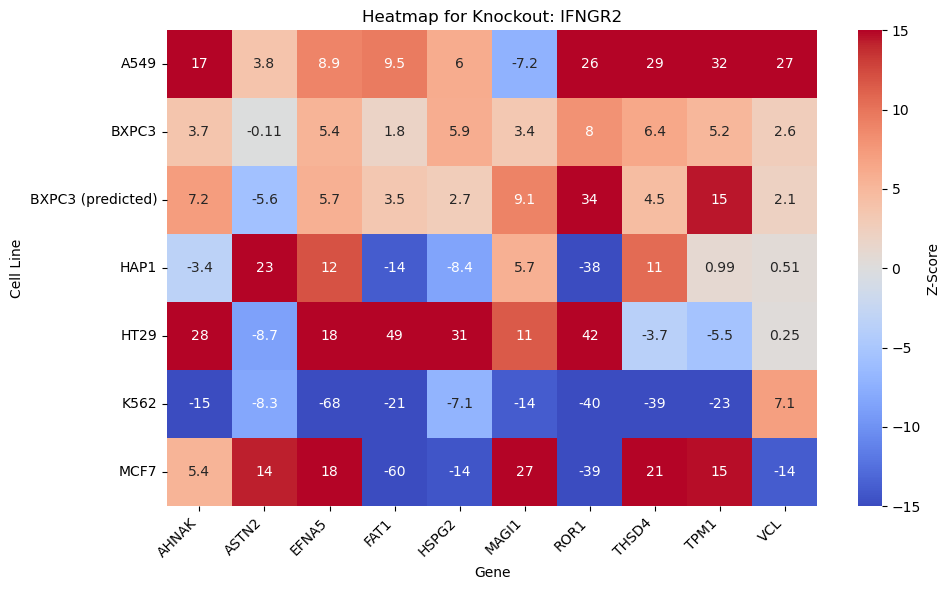

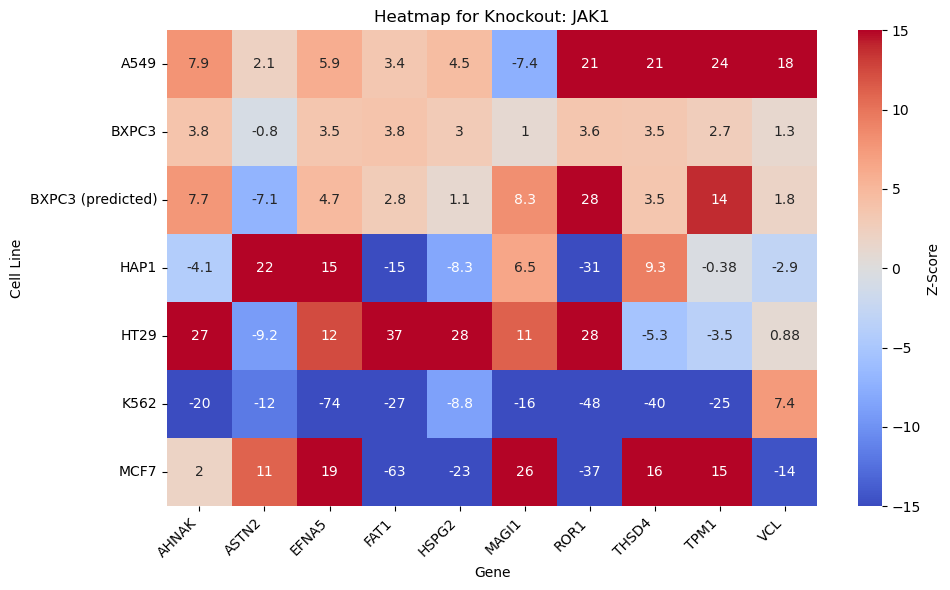

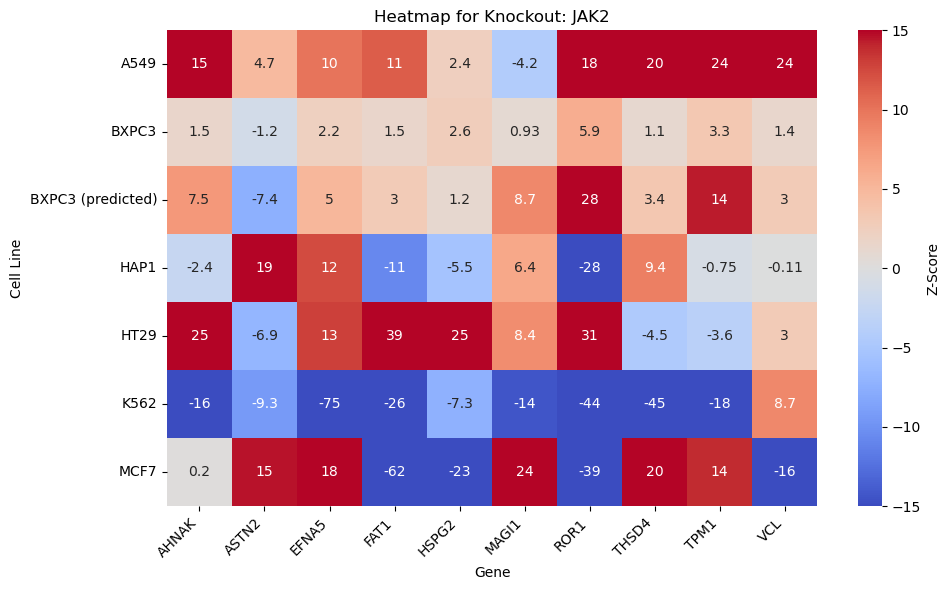

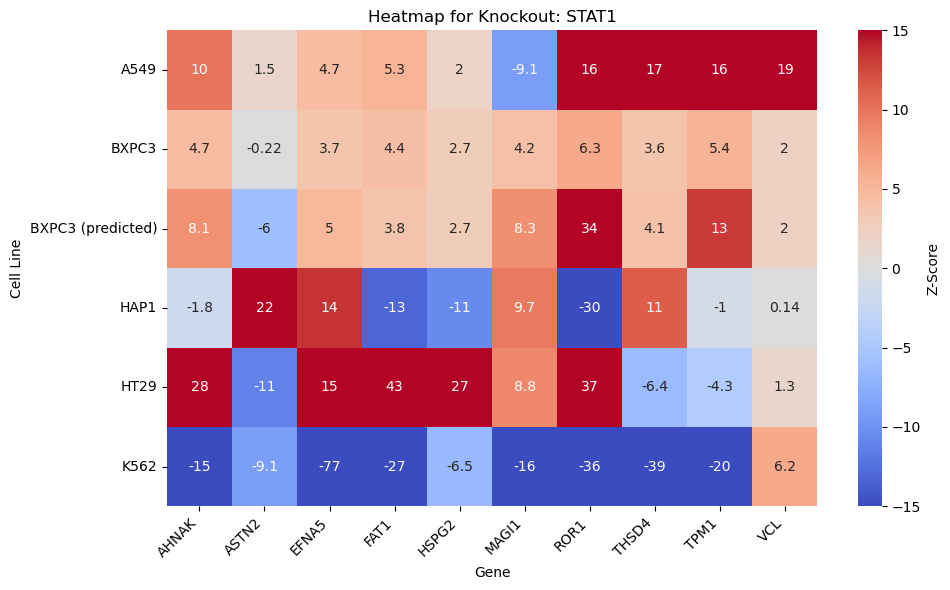

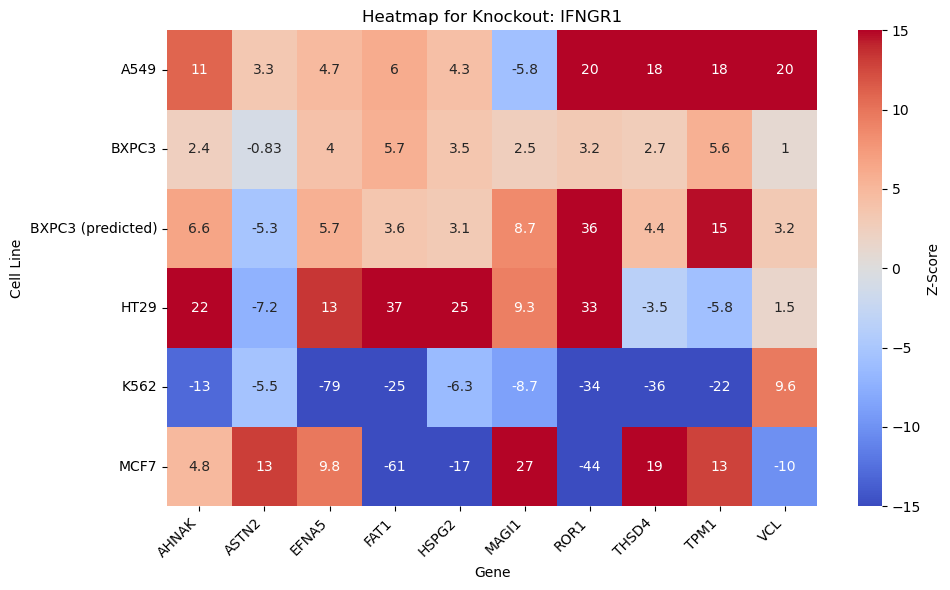

In [ ]:
# Reproduce examples from previous downstream analysis

knockouts = ['IFNGR2', 'JAK1', 'JAK2', 'STAT1', 'IFNGR1']
pathways = ['IFNG']
cell_types = ['BXPC3 (predicted)', 'BXPC3', 'HAP1', 'K562', 'A549', 'HT29', 'MCF7']
genes = [
    "THSD4", "FAT1", "HSPG2", "VCL", "MAGI1", "EFNA5", 
    "TPM1", "ASTN2", "ROR1", "AHNAK"
]

df_uc1 = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout(df_uc1)

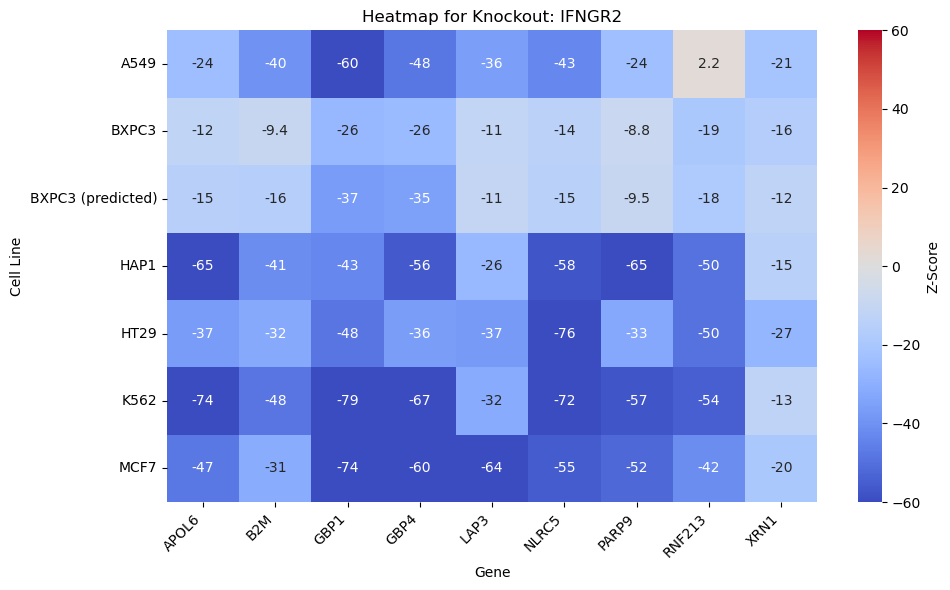

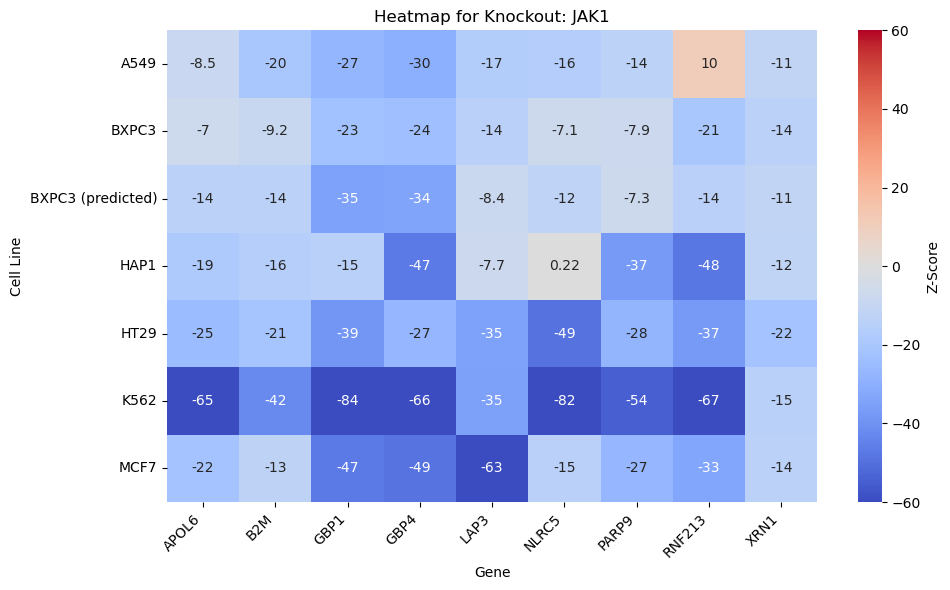

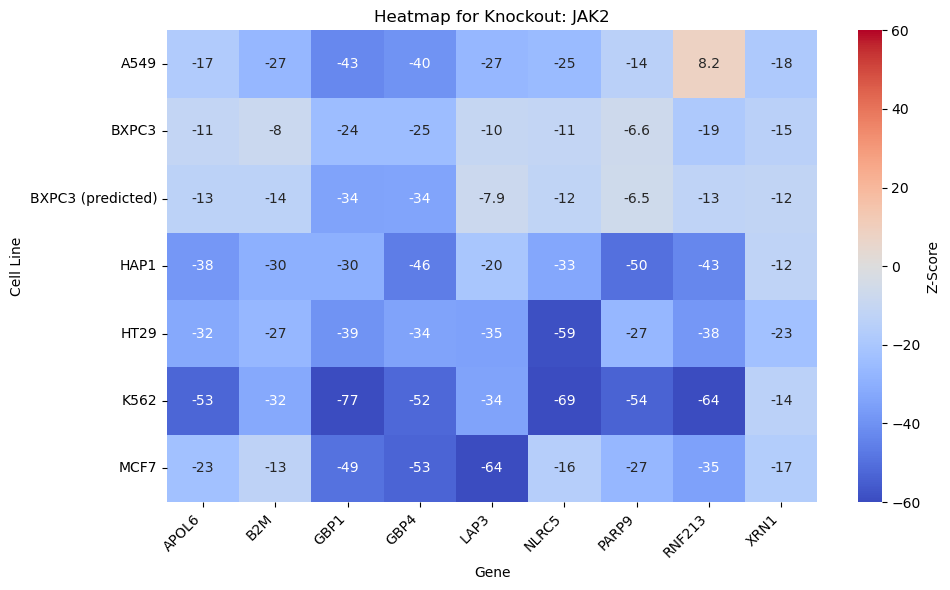

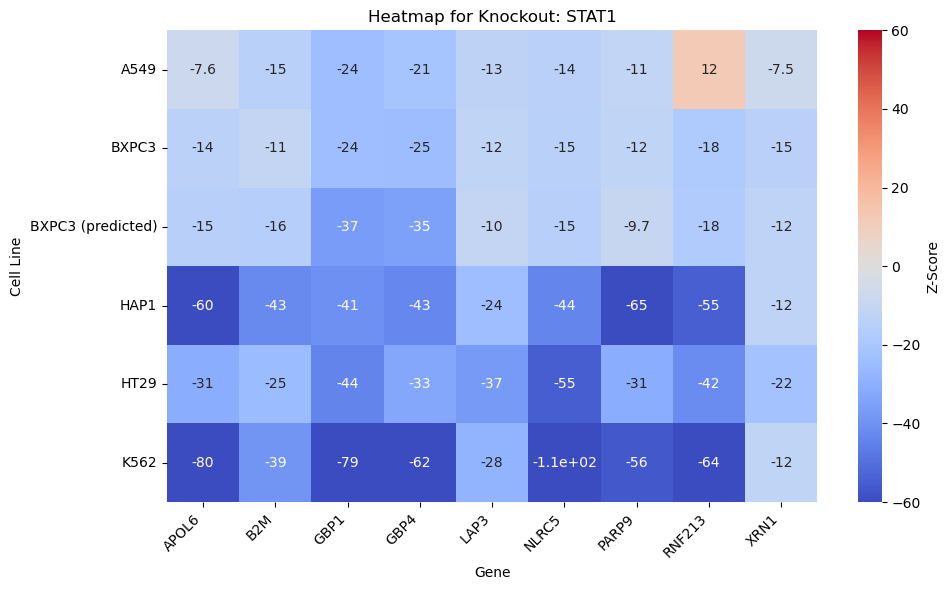

In [93]:
pathways = ['IFNG']
cell_types = ['BXPC3 (predicted)', 'BXPC3', 'HAP1', 'K562', 'A549', 'HT29', 'MCF7']
knockouts = ['IFNGR2', 'JAK1', 'JAK2', 'STAT1']
genes = ['RNF213', 'NLRC5', 'GBP1', 'LAP3', 'PARP9', 'APOL6', 'B2M', 'GBP4', 'XRN1']

df_uc2 = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout(df_uc2, vmin=-60, vmax=60)

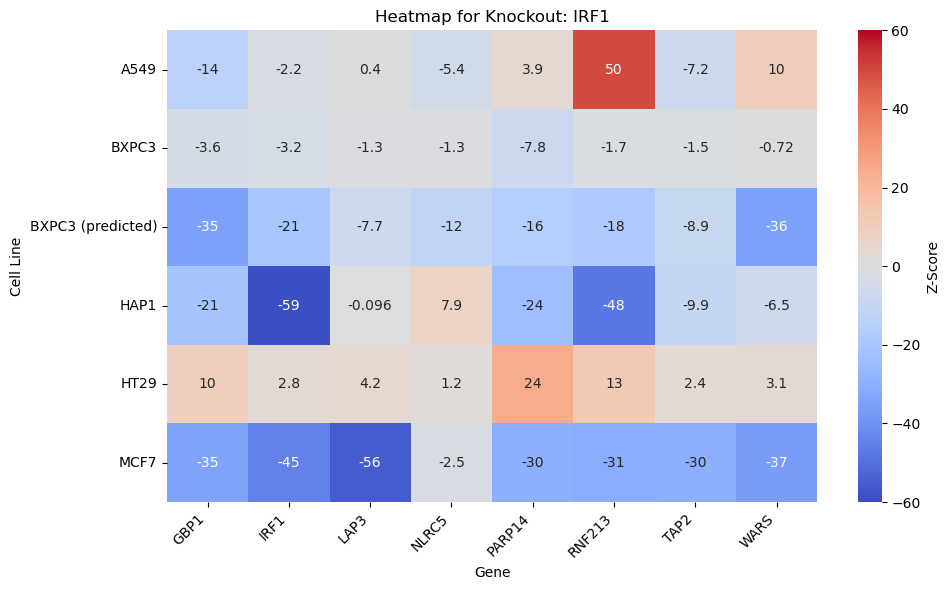

In [101]:
# all other cell types show strong effect to IRF1, but not BXPC3, here very similar to K562 and different to HT29 in contrast to before
pathways = ['IFNG']
cell_types = ['BXPC3 (predicted)', 'BXPC3', 'HAP1', 'K562', 'A549', 'HT29', 'MCF7']
knockouts = ['IRF1']
genes = ['WARS', 'TAP2', 'RNF213', 'PARP14', 'NLRC5', 'LAP3', 'IRF1', 'GBP1']

df_uc3 = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout(df_uc3, vmin=-60, vmax=60)

## 3) quantification of the similarities of z-scores (NAE, pearson correlation) of the predicted effects vs effects in all cell lines

In [ ]:
df_results = calculate_similarities(df_predicted_filtered, df_ground_truth_filtered)
df_results

,cell_line_predicted,cell_line,NAE,pearson_correlation
0,BXPC3 (predicted),A549,1.398062e+06,0.014907
1,BXPC3 (predicted),HAP1,1.911769e+06,0.065033
2,BXPC3 (predicted),HT29,2.578015e+06,-0.006070
3,BXPC3 (predicted),K562,1.715851e+06,0.074777
4,BXPC3 (predicted),MCF7,3.547668e+06,0.004464
5,BXPC3 (predicted),BXPC3,1.047551e+07,0.366331


In [129]:
# create deg per pathway and knockout, independent of cell type
deg = test.uns['rank_genes_groups_cov_all']
deg_temp = defaultdict(set)
for key, genes in deg.items():
    _, pathway, knockout = key.split('_')
    new_key = f"{pathway}_{knockout}"
    deg_temp[new_key].update(genes)
deg_temp = {key: list(genes) for key, genes in deg_temp.items()}

deg_combined = {}
for key, genes in deg.items():
    celltype, pathway, knockout = key.split('_')
    combined_key = f"{celltype}_{pathway}_{knockout}"
    combined_genes = list(deg_temp[f"{pathway}_{knockout}"])
    deg_combined[combined_key] = combined_genes
    combined_key = f"{celltype} (predicted)_{pathway}_{knockout}"
    deg_combined[combined_key] = combined_genes

In [134]:
df_predicted_deg = filter_deg_optimized(df_predicted_filtered, deg_combined)
df_measured_deg = filter_deg_optimized(df_ground_truth_filtered, deg_combined)

/tmp/ipykernel_3453710/294086113.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'] = df['cell_line'] + '_' + df['pathway'] + '_' + df['knockout']
/tmp/ipykernel_3453710/294086113.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'] = df['cell_line'] + '_' + df['pathway'] + '_' + df['knockout']


In [ ]:
df_results = calculate_similarities(df_predicted_deg, df_measured_deg)
df_results

,cell_line_predicted,cell_line,NAE,pearson_correlation
0,BXPC3 (predicted),A549,12941.103516,-0.012765
1,BXPC3 (predicted),HAP1,15913.539062,0.127486
2,BXPC3 (predicted),HT29,23580.152344,-0.084795
3,BXPC3 (predicted),K562,15299.652344,0.048126
4,BXPC3 (predicted),MCF7,27492.708984,-0.041953
5,BXPC3 (predicted),BXPC3,130599.601562,0.316095
